# Project

# Useful things

# Olfaction

**Summary:** In this tutorial, we will implement a something that can change the world.

The detailed documentation of the `OdorArena` class can be found in the [API reference](https://neuromechfly.org/api_ref/arena.html#flygym.mujoco.arena.OdorArena). Its implementation is beyond the scope of this tutorial but can be found [here](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/mujoco/arena/sensory_environment.py).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from gymnasium.utils.env_checker import check_env

from flygym import Fly, Camera
from flygym.arena import FlatTerrain
from flygym.examples.obstacle_arena import ObstacleOdorArena
from flygym.examples.turning_controller import HybridTurningNMF

In [2]:
from pathlib import Path

Path("./outputs").mkdir(exist_ok=True)

In [5]:
# We start by creating a simple arena
flat_terrain_arena = FlatTerrain()

# Then, we add visual and olfactory features on top of it
arena = ObstacleOdorArena(
    terrain=flat_terrain_arena,
    obstacle_positions=np.array([(0, 0), (0, 0), (0, 0)]),
    marker_size=0.5,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)

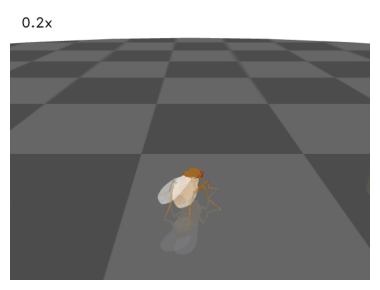

In [6]:
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = Fly(
    spawn_pos=(13, -5, 0.2),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(70)),
    contact_sensor_placements=contact_sensor_placements,
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
)

cam = Camera(fly=fly, play_speed=0.2, camera_id="user_cam")
sim = HybridTurningNMF(fly=fly, cameras=[cam], arena=arena)

for i in range(500):
    obs, reward, terminated, truncated, info = sim.step(np.zeros(2))
    sim.render()

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(cam._frames[-1])
ax.axis("off")
fig.savefig("./outputs/vision_sim_env.png")

====================================================================================================

In [9]:
from flygym.arena import BaseArena
from flygym.examples.obstacle_arena import ObstacleOdorArena
import numpy as np
from typing import Union, Tuple, List, Optional, Callable

class SquareOdorArena(ObstacleOdorArena):
    def __init__(
        self,   
        terrain: BaseArena,
        odor_zone_center: Tuple[float, float] = (12.5, 12.5),
        odor_zone_size: float = 10.0,
        odor_zone_intensity: float = 1.0,
        **kwargs
    ):
        super().__init__(terrain=terrain, **kwargs)
        self.odor_zone_center = np.array(odor_zone_center)
        self.odor_zone_size = odor_zone_size
        self.odor_zone_intensity = odor_zone_intensity

    def get_olfaction(self, antennae_pos: np.ndarray) -> np.ndarray:
        """Calcule l'intensité de l'odeur pour chaque antenne dans la zone carrée."""
        intensity = np.zeros((len(antennae_pos),))
        for i, pos in enumerate(antennae_pos):
            if (abs(pos[0] - self.odor_zone_center[0]) <= self.odor_zone_size / 2 and
                abs(pos[1] - self.odor_zone_center[1]) <= self.odor_zone_size / 2):
                # L'intensité diminue linéairement depuis le centre
                distance = np.linalg.norm(pos - self.odor_zone_center)
                intensity[i] = self.odor_zone_intensity * (1 - distance / (self.odor_zone_size / 2))
        return intensity
    
    def get_spawn_position(self, rel_pos: np.ndarray, rel_angle: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Return a fixed spawn position and angle."""
        spawn_pos = np.array([0.0, 0.0, 0.0])  # Replace with your actual values
        spawn_angle = np.array([0.0, 0.0, 0.0])  # Replace with your actual values
        return spawn_pos, spawn_angle

ModuleNotFoundError: No module named 'flygym.arena'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from flygym.examples.obstacle_arena import ObstacleOdorArena

# Définition d'un terrain simple comme base pour l'arène
class SimpleTerrain(BaseArena):
    #def __init__(self):
        #self.root_element = self.create_default_root()

    def get_spawn_position(self, rel_pos, rel_angle):
        return rel_pos, rel_angle  # Retour simple des paramètres d'entrée

    def create_default_root(self):
        class RootElement:
            def __init__(self):
                self.worldbody = self.WorldBody()
                self.assets = self.AssetManager()  # Assurez-vous que le nom est correct

            class WorldBody:
                def add(self, obj_type, **kwargs):
                    print(f"Ajout d'un objet de type {obj_type} avec les arguments {kwargs}")
                    return self  # Simuler l'ajout d'un objet

            class AssetManager:
                def add(self, asset_type, **kwargs):
                    print(f"Ajout d'un asset de type {asset_type} avec les arguments {kwargs}")
                    return self  # Simuler l'ajout d'un asset

        return RootElement()

# Création de l'instance de terrain
base_terrain = SimpleTerrain()

# Initialize the SquareOdorArena avec le terrain créé
arena = SquareOdorArena(terrain=base_terrain, odor_zone_center=(12.5, 12.5), odor_zone_size=10.0, odor_zone_intensity=1.0)

# Create a grid of points
x = np.linspace(0, 25, 100)
y = np.linspace(0, 25, 100)
X, Y = np.meshgrid(x, y)

# Calculate the odor intensity for each point
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        # Ajustement nécessaire: get_olfaction attend une position d'antenne 3D, ajoutons une dimension z arbitraire.
        Z[i, j] = arena.get_olfaction(np.array([[X[i, j], Y[i, j], 0]]))  # z=0 pour simplifier

# Create a heatmap
plt.imshow(Z, origin='lower', extent=[0, 25, 0, 25], cmap='hot', interpolation='nearest')
plt.colorbar(label='Odor intensity')
plt.title('Odor intensity in SquareOdorArena')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


IndentationError: expected an indented block after function definition on line 7 (74544131.py, line 10)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the SquareOdorArena
#arena = SquareOdorArena(terrain=base, odor_zone_center=(12.5, 12.5), odor_zone_size=10.0, odor_zone_intensity=1.0)
arena = SquareOdorArena(terrain=base_terrain)

# Create a grid of points
x = np.linspace(0, 25, 100)
y = np.linspace(0, 25, 100)
X, Y = np.meshgrid(x, y)

# Calculate the odor intensity for each point
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i, j] = arena.get_olfaction(np.array([[X[i, j], Y[i, j]]]))

# Create a heatmap
plt.imshow(Z, origin='lower', extent=[0, 25, 0, 25], cmap='hot', interpolation='nearest')
plt.colorbar(label='Odor intensity')
plt.title('Odor intensity in SquareOdorArena')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

AttributeError: 'NoneType' object has no attribute 'worldbody'

## Odor arena

To demonstrate odor sensing, let's create an environment with one attractive odor source and two aversive odor sources. The dimension of this odor space is 2 (attractive, aversive) despite the number of odor sources being 3. The odor sources share a peak intensity of 1. We will color the attractive odor source orange and the aversive odor sources blue.

In [ ]:
import numpy as np

# random state seed for reproducibility
seed = 1

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[1, 0], [0, 1], [0, 1]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14], [31, 119, 180], [31, 119, 180]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])

Let's create the arena using these parameters. The detailed documentation of the `OdorArena` class can be found in the [API reference](https://neuromechfly.org/api_ref/arena.html#flygym.mujoco.arena.OdorArena). Its implementation is beyond the scope of this tutorial but can be found [here](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/mujoco/arena/sensory_environment.py).

In [ ]:
from flygym.arena import OdorArena

arena = OdorArena(
    odor_source=odor_source,
    peak_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)

TypeError: OdorArena.__init__() got an unexpected keyword argument 'peak_intensity'

Let’s place our fly in the arena. As before, we will run a few iterations to allow it to stand on the ground in a stable manner.

Note that we will be using the `HybridTurningNMF` as the turning controller. This class serves as an enhanced version of the `TurningNMF` in the previous exercises, utilizing sensory feedback to prevent the fly from stumbling. For further details, refer to https://neuromechfly.org/tutorials/hybrid_controller.html and https://neuromechfly.org/tutorials/turning.html.

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from flygym import Parameters
from flygym.examples.turning_controller import HybridTurningNMF


Path("./outputs").mkdir(exist_ok=True)


contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
)
for i in range(500):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")
fig.savefig("./outputs/olfaction_env.png")

NameError: name 'arena' is not defined

We can visualize the fly trajectory:

In [ ]:
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 25)
ax.set_ylim(-5, 5)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig("./outputs/odor_taxis_trajectory.png")

NameError: name 'obs_hist' is not defined

We can also generate the video:

In [ ]:
sim.save_video("./outputs/odor_taxis.mp4")

from IPython import display

display.Video("./outputs/odor_taxis.mp4")

NameError: name 'sim' is not defined